In [ ]:
from DataGenerator import DataGenerator

In [2]:
train_data = DataGenerator()

In [3]:
from keras.models import Model, load_model
import tensorflow as tf
import keras
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
from keras.optimizers import adam
from keras import backend as K
from datetime import datetime

Using TensorFlow backend.


In [4]:
#defining some custom loss functions and accuracy metrics in order to evaluate the model inside the jupyter notebook
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [5]:
inputs = Input((400, 400, 3))
s = Lambda(lambda x: x / 255) (inputs)

def convLevel(filters, kernel_size, dropout, input_vec):
  conv = Conv2D(filters, kernel_size, activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (input_vec)
  conv = BatchNormalization() (conv)
  conv = Dropout(dropout) (conv)
  conv = Conv2D(filters, kernel_size, activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (conv)
  conv = BatchNormalization() (conv)
  return conv

conv1 = convLevel(16, (3, 3), 0.1, inputs)
layer_1 = MaxPooling2D((2, 2)) (conv1)

conv2 = convLevel(32, (3, 3), 0.1, layer_1)
layer_2 = MaxPooling2D((2, 2)) (conv2)

conv3 = convLevel(64, (3, 3), 0.2, layer_2)
layer_3 = MaxPooling2D((2, 2)) (conv3)

conv4 = convLevel(128, (3, 3), 0.2, layer_3)
layer_4 = MaxPooling2D((2, 2)) (conv4)

conv5 = convLevel(256, (3, 3), 0.3, layer_4)

def convLevelTranspose(filters, dropout, input_vec, to_concatenate, axis= -1):
  upsample = Conv2DTranspose(filters, (2, 2), strides= (2, 2), padding= 'same') (input_vec)
  upsample = concatenate([upsample, to_concatenate], axis= axis)

  conv = Conv2D(filters, (3, 3), activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (upsample)
  conv = BatchNormalization() (conv)
  conv = Dropout(dropout) (conv)
  conv = Conv2D(filters, (3, 3), activation= 'elu', kernel_initializer= 'he_normal', padding= 'same') (conv)
  conv = BatchNormalization() (conv)
  return conv

conv6 = convLevelTranspose(128, 0.2, conv5, conv4)
conv7 = convLevelTranspose(64, 0.2, conv6, conv3)
conv8 = convLevelTranspose(32, 0.2, conv7, conv2)
conv9 = convLevelTranspose(32, 0.2, conv8, conv1, 3)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (conv9)

model = Model(inputs= [inputs], outputs= [outputs])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 400, 400, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 400, 400, 16) 0           batch_normalization_1[0][0]      
__________

In [6]:
#hyperparameters #50 -> 0.0001; 15 -> 0.00001;
EPOCHS = 350
L_RATE = 0.00001
B_SIZE = 16

In [7]:
optimizer = keras.optimizers.adam(L_RATE)
model.compile(optimizer= optimizer, loss= soft_dice_loss, metrics= [iou_coef, dice_coef])

In [8]:
train_set = train_data.return_data_set()
valid_set = train_data.return_validation_set()

In [9]:
import numpy as np

train_images = np.array(train_set[0])
train_truths = np.expand_dims(np.array(train_set[1]), -1)

In [10]:
val_labels = np.array(valid_set[1])
val_images = np.array(valid_set[0])
val_tuple = (val_images, np.expand_dims(val_labels, -1))

In [11]:
model.fit(train_images, train_truths, validation_data= val_tuple, epochs= EPOCHS, batch_size= B_SIZE)


Train on 408 samples, validate on 10 samples
Epoch 1/350
408/408 [==============================] - 36s 87ms/step - loss: 0.7187 - iou_coef: 0.1623 - dice_coef: 0.2824 - val_loss: 0.6645 - val_iou_coef: 0.2019 - val_dice_coef: 0.3355
Epoch 2/350
408/408 [==============================] - 18s 45ms/step - loss: 0.7051 - iou_coef: 0.1717 - dice_coef: 0.2959 - val_loss: 0.6649 - val_iou_coef: 0.2017 - val_dice_coef: 0.3351
Epoch 3/350
408/408 [==============================] - 18s 43ms/step - loss: 0.6912 - iou_coef: 0.1804 - dice_coef: 0.3087 - val_loss: 0.6587 - val_iou_coef: 0.2066 - val_dice_coef: 0.3413
Epoch 4/350
408/408 [==============================] - 17s 43ms/step - loss: 0.6773 - iou_coef: 0.1900 - dice_coef: 0.3220 - val_loss: 0.6444 - val_iou_coef: 0.2178 - val_dice_coef: 0.3556
Epoch 5/350
408/408 [==============================] - 18s 43ms/step - loss: 0.6625 - iou_coef: 0.2012 - dice_coef: 0.3376 - val_loss: 0.6228 - val_iou_coef: 0.2350 - val_dice_coef: 0.3772
Epoch 6/3

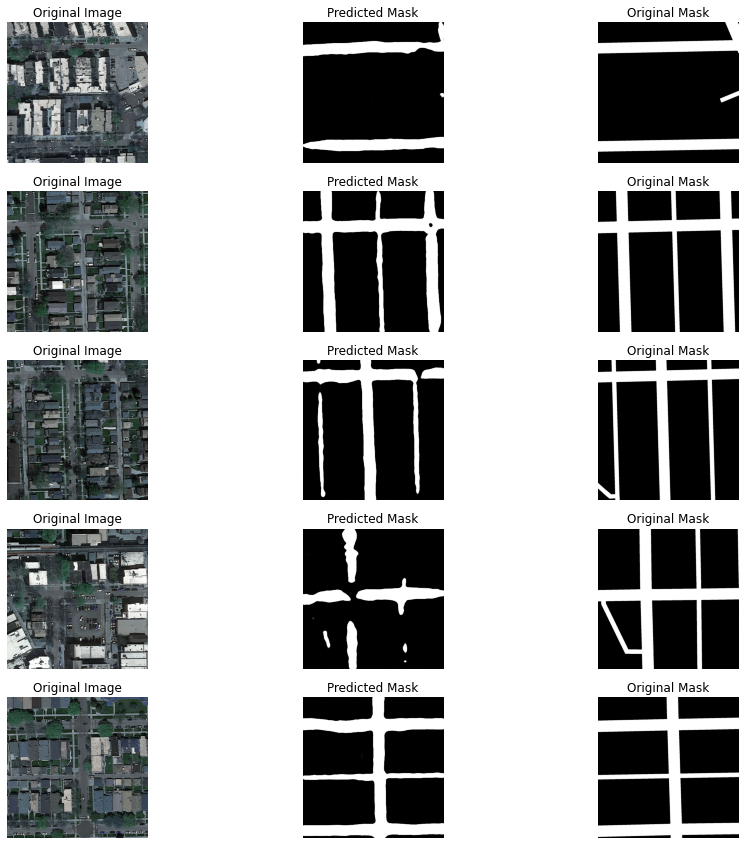

In [12]:
from visualization import display_predictions
import matplotlib.pyplot as plt

plt.figure(figsize= (15, 15))

display_predictions(val_images, model.predict(val_images), val_labels)

In [13]:
from Labelizer import Labelizer

In [14]:
labelizer = Labelizer()

In [15]:
groundtruths = labelizer.make_submission(val_labels)[0]

In [16]:
val_predictions = model.predict(val_images).reshape(-1, 400, 400,)

In [17]:
predictions_labs = labelizer.make_submission(val_predictions)[0]

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(groundtruths, predictions_labs)

0.93904

In [19]:
model.save("model-iou.h5", overwrite=True, include_optimizer=False)